In [2]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)


In [3]:
# Define the path to the dataset
base_path = '/Users/admin/AIEngineer/DeepFakeProject/Dataset/Faceplus2'
categories = ['fake', 'real']

# Initialize a list to hold data
data = []

# Process each category
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

# Convert the data to a DataFrame
df = pd.DataFrame(data)

In [4]:
# Đảm bảo đã có df_cropped.csv chứa đường dẫn ảnh đã crop
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})
df


,filename,path,id,frame,label,label_id
0,596_609_frame_0019.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,596,19,fake,0
1,746_571_frame_0008.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,746,8,fake,0
2,514_443_frame_0028.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,514,28,fake,0
3,642_635_frame_0006.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,642,6,fake,0
4,937_888_frame_0009.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,937,9,fake,0
...,...,...,...,...,...,...
59803,727_frame_0009.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,727,9,real,1
59804,832_frame_0026.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,832,26,real,1
59805,059_frame_0005.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,59,5,real,1
59806,572_frame_0008.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,572,8,real,1


In [5]:
df['video_key'] = df['id'].astype(str) + "_" + df['label']

from collections import defaultdict

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']


In [6]:
labels 


{'596_fake': 0,
 '746_fake': 0,
 '514_fake': 0,
 '642_fake': 0,
 '937_fake': 0,
 '0_fake': 0,
 '241_fake': 0,
 '174_fake': 0,
 '308_fake': 0,
 '348_fake': 0,
 '793_fake': 0,
 '961_fake': 0,
 '991_fake': 0,
 '653_fake': 0,
 '341_fake': 0,
 '304_fake': 0,
 '687_fake': 0,
 '719_fake': 0,
 '90_fake': 0,
 '38_fake': 0,
 '827_fake': 0,
 '605_fake': 0,
 '454_fake': 0,
 '244_fake': 0,
 '418_fake': 0,
 '4_fake': 0,
 '538_fake': 0,
 '79_fake': 0,
 '128_fake': 0,
 '146_fake': 0,
 '766_fake': 0,
 '155_fake': 0,
 '579_fake': 0,
 '581_fake': 0,
 '692_fake': 0,
 '580_fake': 0,
 '898_fake': 0,
 '641_fake': 0,
 '171_fake': 0,
 '737_fake': 0,
 '832_fake': 0,
 '337_fake': 0,
 '510_fake': 0,
 '879_fake': 0,
 '408_fake': 0,
 '143_fake': 0,
 '487_fake': 0,
 '865_fake': 0,
 '73_fake': 0,
 '682_fake': 0,
 '287_fake': 0,
 '743_fake': 0,
 '922_fake': 0,
 '407_fake': 0,
 '133_fake': 0,
 '850_fake': 0,
 '234_fake': 0,
 '478_fake': 0,
 '325_fake': 0,
 '840_fake': 0,
 '886_fake': 0,
 '611_fake': 0,
 '125_fake': 0,


In [7]:
!pip install opencv-python

In [6]:
 import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from scipy.stats import mode

# Giả định đã có
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 16
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []

# Data generator
class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=10, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15 if augment else 0,
            zoom_range=0.1 if augment else 0,
            horizontal_flip=augment
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X, batch_y = [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            imgs = []
            for path in frames:
                img = cv2.imread(path)
                img = cv2.resize(img, self.img_size)
                img = self.datagen.random_transform(img) if self.augment else img
                img = img.astype('float32') / 255.0
                imgs.append(img)
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))
            batch_X.append(imgs)
            batch_y.append(self.labels[key])

        return np.array(batch_X), np.array(batch_y)

# Build model cải tiến
def build_model(sequence_len, img_size):
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')

    # Freeze toàn bộ backbone để giảm overfit
    base_cnn.trainable = False

    # CNN feature extractor
    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)

    # Sequence input
    input_seq = Input(shape=(sequence_len, *img_size, 3))
    x = TimeDistributed(cnn_model)(input_seq)

    # LSTM đơn giản hơn
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)

    # Không dùng nhiều Dense, chỉ một đầu ra
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_seq, outputs=output)
    return model

# HMM cải tiến
def hmm_postprocess(pred_probs, y_true, n_states=2):
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        if len(state_labels) > 0:
            mapped_label = mode(state_labels, keepdims=True).mode[0]
        else:
            mapped_label = 0  # fallback
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# Training K-Fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n===== Fold {fold} =====")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.1, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen = VideoSequence(val_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen = VideoSequence(test_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size)
    model.compile(optimizer=SGD(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    model_path = f"best_model_fold{fold}.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                        callbacks=[checkpoint, earlystop, reduce_lr], verbose=1)
    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred),
        'recall': recall_score(y_true, y_hmm_pred),
        'f1': f1_score(y_true, y_hmm_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })

print("\n📊 Tổng kết kết quả các fold:")
for r in results:
    print(f"Fold {r['fold']}: Accuracy={r['accuracy']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")



===== Fold 1 =====


2025-06-14 22:27:27.995050: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-06-14 22:27:27.995077: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-14 22:27:27.995084: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-14 22:27:27.995129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-14 22:27:27.995157: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2025-06-14 22:27:30.885805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-06-14 22:27:30.963256: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp_4.


90/90 [==============================] - ETA: 0s - loss: 0.7272 - accuracy: 0.5139
Epoch 1: val_accuracy improved from -inf to 0.53125, saving model to best_model_fold1.h5


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 56s 585ms/step - loss: 0.7272 - accuracy: 0.5139 - val_loss: 0.6897 - val_accuracy: 0.5312 - lr: 1.0000e-04
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.7241 - accuracy: 0.5160
Epoch 2: val_accuracy improved from 0.53125 to 0.55625, saving model to best_model_fold1.h5
90/90 [==============================] - 58s 646ms/step - loss: 0.7241 - accuracy: 0.5160 - val_loss: 0.6859 - val_accuracy: 0.5562 - lr: 1.0000e-04
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.7173 - accuracy: 0.5104
Epoch 3: val_accuracy improved from 0.55625 to 0.60000, saving model to best_model_fold1.h5
90/90 [==============================] - 51s 565ms/step - loss: 0.7173 - accuracy: 0.5104 - val_loss: 0.6831 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.5236
Epoch 4: val_accuracy did not improve from 0.60000
90/90 [=============================

Epoch 1/50


2025-06-14 22:33:56.932181: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp_4.


90/90 [==============================] - ETA: 0s - loss: 0.7369 - accuracy: 0.4861
Epoch 1: val_accuracy improved from -inf to 0.46875, saving model to best_model_fold2.h5


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 52s 553ms/step - loss: 0.7369 - accuracy: 0.4861 - val_loss: 0.7288 - val_accuracy: 0.4688 - lr: 1.0000e-04
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.7324 - accuracy: 0.4917
Epoch 2: val_accuracy improved from 0.46875 to 0.47500, saving model to best_model_fold2.h5
90/90 [==============================] - 61s 678ms/step - loss: 0.7324 - accuracy: 0.4917 - val_loss: 0.7271 - val_accuracy: 0.4750 - lr: 1.0000e-04
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.7292 - accuracy: 0.4917
Epoch 3: val_accuracy improved from 0.47500 to 0.48750, saving model to best_model_fold2.h5
90/90 [==============================] - 53s 581ms/step - loss: 0.7292 - accuracy: 0.4917 - val_loss: 0.7256 - val_accuracy: 0.4875 - lr: 1.0000e-04
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 0.7241 - accuracy: 0.5056
Epoch 4: val_accuracy did not improve from 0.48750
90/90 [=============================

Epoch 1/50


2025-06-14 22:45:56.456626: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp_4.


90/90 [==============================] - ETA: 0s - loss: 0.7095 - accuracy: 0.5472
Epoch 1: val_accuracy improved from -inf to 0.58125, saving model to best_model_fold3.h5


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 53s 551ms/step - loss: 0.7095 - accuracy: 0.5472 - val_loss: 0.6970 - val_accuracy: 0.5813 - lr: 1.0000e-04
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.7061 - accuracy: 0.5403
Epoch 2: val_accuracy did not improve from 0.58125
90/90 [==============================] - 49s 540ms/step - loss: 0.7061 - accuracy: 0.5403 - val_loss: 0.6956 - val_accuracy: 0.5437 - lr: 1.0000e-04
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.7028 - accuracy: 0.5417
Epoch 3: val_accuracy did not improve from 0.58125
90/90 [==============================] - 50s 548ms/step - loss: 0.7028 - accuracy: 0.5417 - val_loss: 0.6943 - val_accuracy: 0.5375 - lr: 1.0000e-04
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.5472
Epoch 4: val_accuracy did not improve from 0.58125
90/90 [==============================] - 49s 543ms/step - loss: 0.7013 - accuracy: 0.5472 - val_loss: 0.6930 - val_acc

Epoch 1/50


2025-06-14 22:50:17.494189: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp_4.


90/90 [==============================] - ETA: 0s - loss: 0.7182 - accuracy: 0.5222
Epoch 1: val_accuracy improved from -inf to 0.49375, saving model to best_model_fold4.h5


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 52s 537ms/step - loss: 0.7182 - accuracy: 0.5222 - val_loss: 0.7255 - val_accuracy: 0.4938 - lr: 1.0000e-04
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.7109 - accuracy: 0.5375
Epoch 2: val_accuracy did not improve from 0.49375
90/90 [==============================] - 48s 533ms/step - loss: 0.7109 - accuracy: 0.5375 - val_loss: 0.7170 - val_accuracy: 0.4875 - lr: 1.0000e-04
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.5382
Epoch 3: val_accuracy did not improve from 0.49375
90/90 [==============================] - 50s 548ms/step - loss: 0.7005 - accuracy: 0.5382 - val_loss: 0.7108 - val_accuracy: 0.4938 - lr: 1.0000e-04
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 0.6997 - accuracy: 0.5368
Epoch 4: val_accuracy improved from 0.49375 to 0.50625, saving model to best_model_fold4.h5
90/90 [==============================] - 50s 551ms/step - loss: 0.6997 - accu

Epoch 1/50


2025-06-14 23:05:22.600652: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp_4.


90/90 [==============================] - ETA: 0s - loss: 0.7505 - accuracy: 0.5083
Epoch 1: val_accuracy improved from -inf to 0.48125, saving model to best_model_fold5.h5


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/90 [==============================] - 52s 553ms/step - loss: 0.7505 - accuracy: 0.5083 - val_loss: 0.7032 - val_accuracy: 0.4812 - lr: 1.0000e-04
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.7400 - accuracy: 0.5042
Epoch 2: val_accuracy did not improve from 0.48125
90/90 [==============================] - 48s 533ms/step - loss: 0.7400 - accuracy: 0.5042 - val_loss: 0.6983 - val_accuracy: 0.4750 - lr: 1.0000e-04
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.7356 - accuracy: 0.5264
Epoch 3: val_accuracy did not improve from 0.48125
90/90 [==============================] - 49s 541ms/step - loss: 0.7356 - accuracy: 0.5264 - val_loss: 0.6952 - val_accuracy: 0.4563 - lr: 1.0000e-04
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 0.7322 - accuracy: 0.5007
Epoch 4: val_accuracy did not improve from 0.48125
90/90 [==============================] - 50s 553ms/step - loss: 0.7322 - accuracy: 0.5007 - val_loss: 0.6928 - val_acc

In [10]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.543500
precision    0.574409
recall       0.333000
f1           0.407123
auc          0.554380
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.5125,0.514124,0.455,0.482759,0.528525
1,2,0.5125,0.523364,0.280,0.364821,0.533300
2,3,0.5100,0.547619,0.115,0.190083,0.511600
3,4,0.6350,0.710938,0.455,0.554878,0.610975
4,5,0.5475,0.576000,0.360,0.443077,0.587500


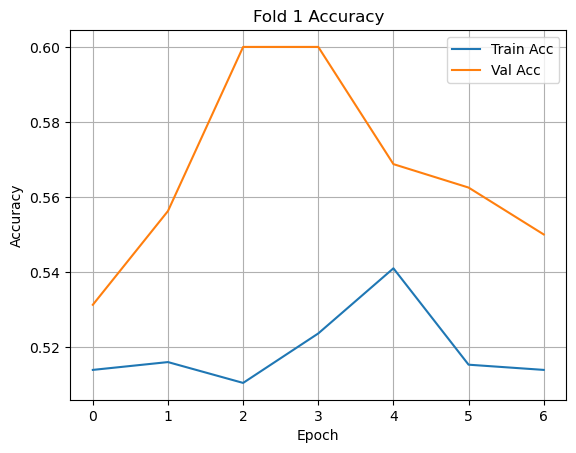

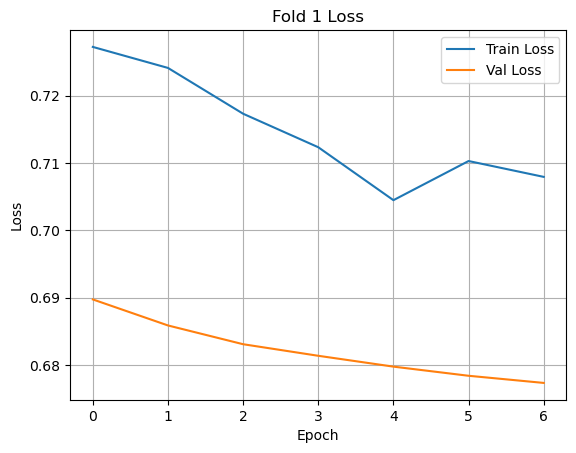

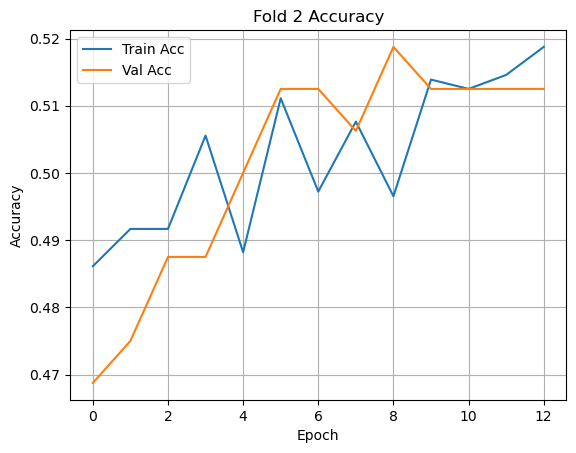

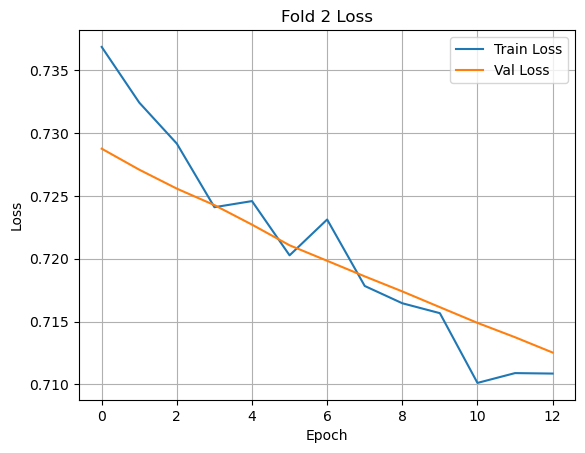

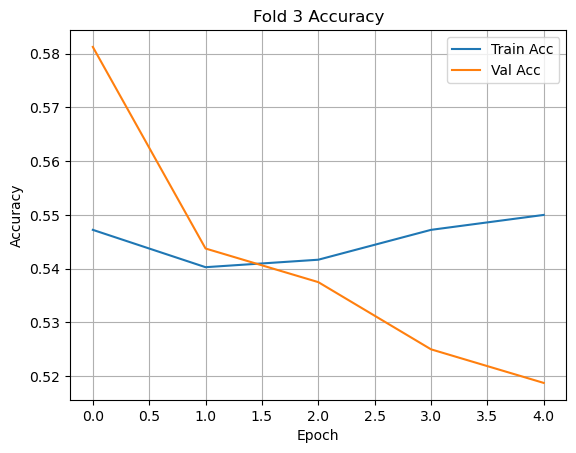

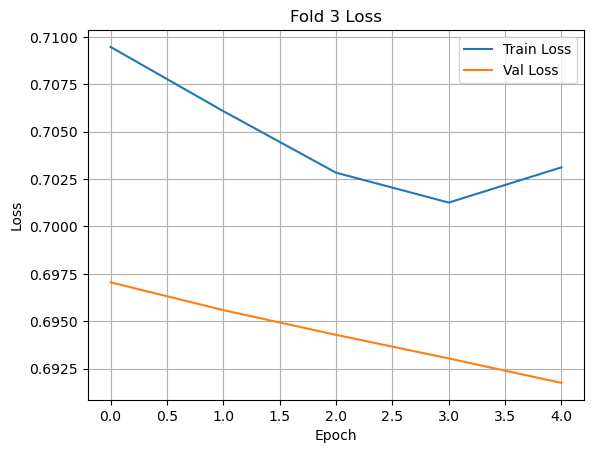

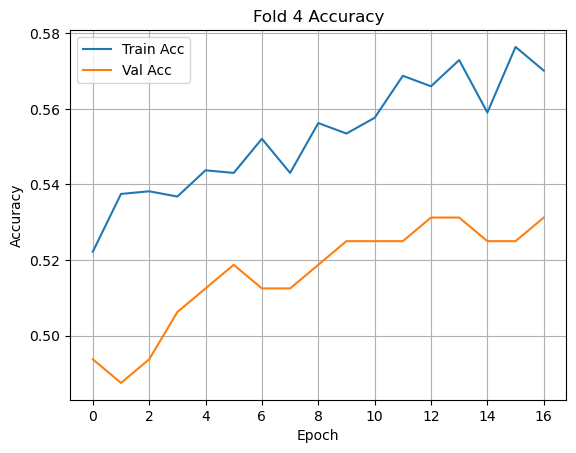

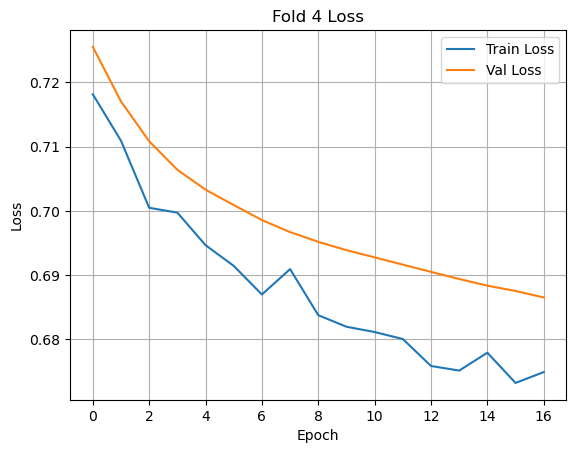

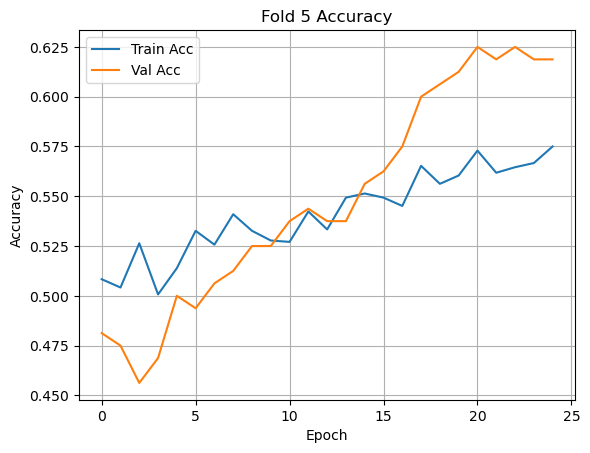

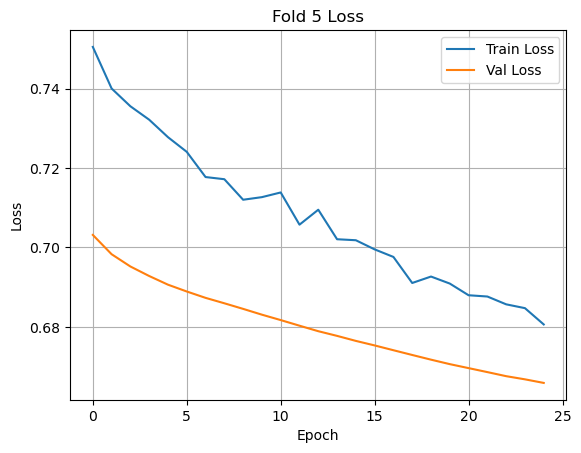

In [11]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
# Save mô hình fold cuối cùng
model.save("mobilenetv2_hmm_sgd_faceplus_final.h5")


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
